In [16]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('raw_train_product.csv')
df.head()

,ds,y,Product
0,2020-01-31,381,Aloevera Hydrating Gel 70g
1,2020-02-28,601,Aloevera Hydrating Gel 70g
2,2020-03-31,618,Aloevera Hydrating Gel 70g
3,2020-04-30,219,Aloevera Hydrating Gel 70g
4,2020-05-31,668,Aloevera Hydrating Gel 70g


In [18]:
# df_group = df.groupby("Product").count()
# df_group = df_group.drop("y", axis=1)
# df_group = df_group.rename(columns = {"ds":"count"})
# df_group = df_group[df_group["count"] == 12]
# df_group = df_group.drop("count", axis=1)
# df_group = df_group.reset_index()

# display(df_group.shape)

# df = df.merge(df_group, how='inner')
# df = df[["ds", "y", "Product"]]
# df["ds"] = pd.to_datetime(df["ds"])
# df = df.sort_values(by=["Product", "ds"])
# df = df.reset_index(drop=True)

# display(df.head())

In [19]:
df.shape

(468, 3)

In [20]:
item = "Aloevera Hydrating Gel 70g"

In [21]:
data = df.loc[(df['Product']==item),:]
data = data.drop("Product", axis=1)
print(data.shape)

(12, 2)


In [22]:
data

,ds,y
0,2020-01-31,381
1,2020-02-28,601
2,2020-03-31,618
3,2020-04-30,219
4,2020-05-31,668
5,2020-06-30,510
6,2020-07-31,168
7,2020-08-31,405
8,2020-09-30,458
9,2020-10-31,476


In [23]:
accuracy_metric = "rmse"
param_grid = {'changepoint_prior_scale': [0.03, 0.05],
              'seasonality_prior_scale': [10]}

In [24]:
def Prophet_forecaster(dataframe, hyperparameters, horizon, accuracy_metric):

    all_params = [dict(zip(hyperparameters.keys(), v)) for v in itertools.product(*hyperparameters.values())]
    kpi = []

    for params in all_params:
        model = Prophet(**params).fit(dataframe)
        dataframe_cv = cross_validation(model, 
                                 horizon = horizon, 
                                 parallel="processes")
        
        dataframe_cv_score = performance_metrics(dataframe_cv, 
                                          rolling_window = 1)
        
        kpi.append(dataframe_cv_score[accuracy_metric].values[0])
        
    best_params = all_params[np.argmin(kpi)]
    
    best_model = Prophet(**best_params)
    best_model.fit(dataframe)
    
    return best_model

In [25]:
model_Prophet = Prophet_forecaster(data, param_grid, '30 days', "rmse")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:Making 15 forecasts with cutoffs between 2020-05-05 00:00:00 and 2020-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE34DA3088>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:Making 15 foreca

In [26]:
df_cv = cross_validation(model_Prophet, 
                         horizon = '30 days', 
                         parallel="processes")

df_cv_score = performance_metrics(df_cv, 
                                  rolling_window = 1)
display(df_cv_score)

INFO:prophet:Making 15 forecasts with cutoffs between 2020-05-05 00:00:00 and 2020-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001EE34C7C048>


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,62646.038311,250.291906,207.489798,0.546103,0.242308,0.446305,0.533333


In [27]:
future = model_Prophet.make_future_dataframe(periods=4, freq='M')
display(future)

,ds
0,2020-01-31
1,2020-02-28
2,2020-03-31
3,2020-04-30
4,2020-05-31
5,2020-06-30
6,2020-07-31
7,2020-08-31
8,2020-09-30
9,2020-10-31


In [28]:
forecast = model_Prophet.predict(future)

display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-31,395.927566,146.945737,643.905112
1,2020-02-28,415.378659,171.918069,660.217025
2,2020-03-31,437.608479,191.793938,673.791860
3,2020-04-30,458.448936,209.313142,712.767318
4,2020-05-31,479.984075,230.037652,732.266650
5,2020-06-30,500.824532,283.590547,749.394685
6,2020-07-31,522.359671,288.350779,760.750663
7,2020-08-31,543.894809,298.329708,781.665012
8,2020-09-30,564.735266,331.501183,798.321590
9,2020-10-31,586.270405,361.985317,843.767068


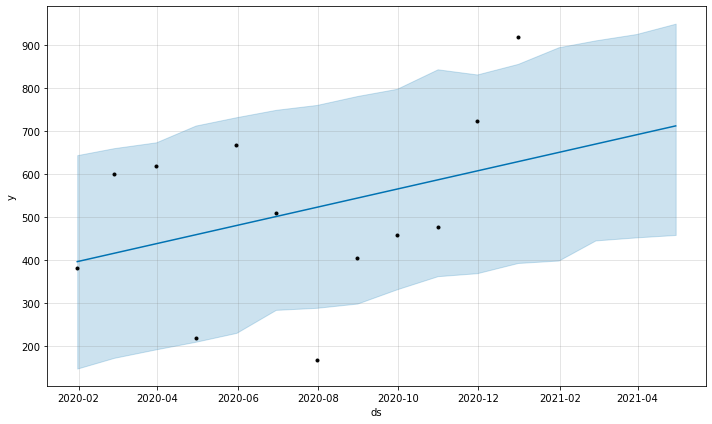

In [29]:
fig1 = model_Prophet.plot(forecast)